# Reparameterizing extreme value framework for improved Bayesian workflow

## Case study on river flow data 

##### Théo Moins, Julyan Arbel, Stéphane Girard, Anne Dutfoy

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import scipy
import csv

from datetime import datetime, timedelta

from src.poisson_process import NHPoissonProcess
from src.mcmc import PoissonMCMC
from src.visualisation import *
from parameters.params import Params
from src.densities import return_level
from src.rhat_infinity import *

COLOR_LIST = ["xkcd:cobalt", 
              "xkcd:turtle green", 
              "xkcd:berry", 
              "xkcd:tangerine", 
              "xkcd:pastel blue"]

# 1. Data extraction

In [2]:
data_file = "data/Golfech_CRUE_1915-2013.txt"



def extract_data(threshold):
    
    observations_under_u = []
    observations_above_u = []

    time_under_u = []
    time_over_u = []
    

    with open(data_file, "r", encoding="ISO-8859-1") as f:
        #skipping the first information lines
        for i in range(7):
            f.readline()

        current_line = f.readline().split()
        current_time = datetime.strptime(current_line[0][1:-1], '%d/%m/%Y')
        while current_line:
            current_time = datetime.strptime(current_line[0][1:-1], '%d/%m/%Y')
            if current_time.month == 12 or current_time.month < 6:
                if float(current_line[1]) > threshold:
                    observations_above_u.append(float(current_line[1]))
                    time_over_u.append(current_time)
                elif float(current_line[1]) > 0:
                    observations_under_u.append(float(current_line[1]))
                    time_under_u.append(current_time)
            current_line = f.readline().split()
        f.close()
    
    return observations_under_u, observations_above_u, time_under_u, time_over_u


def decluster_data(obs, time, cluster_int = 3):
    obs_res, time_res = [], []
    
    idx = 0
    while idx < len(obs)-1: 
        
        current_obs = obs[idx]
        current_time = time[idx]
        while idx < len(obs)-1 and abs(time[idx] - time[idx+1]).days <= cluster_int:
            idx += 1
            current_obs = max(current_obs, obs[idx])
        obs_res.append(current_obs) 
        time_res.append(current_time)
        idx += 1
    return obs_res, time_res


In [3]:
threshold = 2000
decluster = True
n_years = 99

observations_under_u, obs, time_under_u, time = extract_data(threshold = threshold)

if decluster:
    obs, time = decluster_data(obs, time)

n_obs = len(obs)
n_total = len(observations_under_u)+n_obs

print("Total number of observations: {}".format(n_total))
print("Number of observations above u : {}".format(n_obs))
print("Max value : {}".format(max(obs)))

Total number of observations: 17805
Number of observations above u : 182
Max value : 7550.0


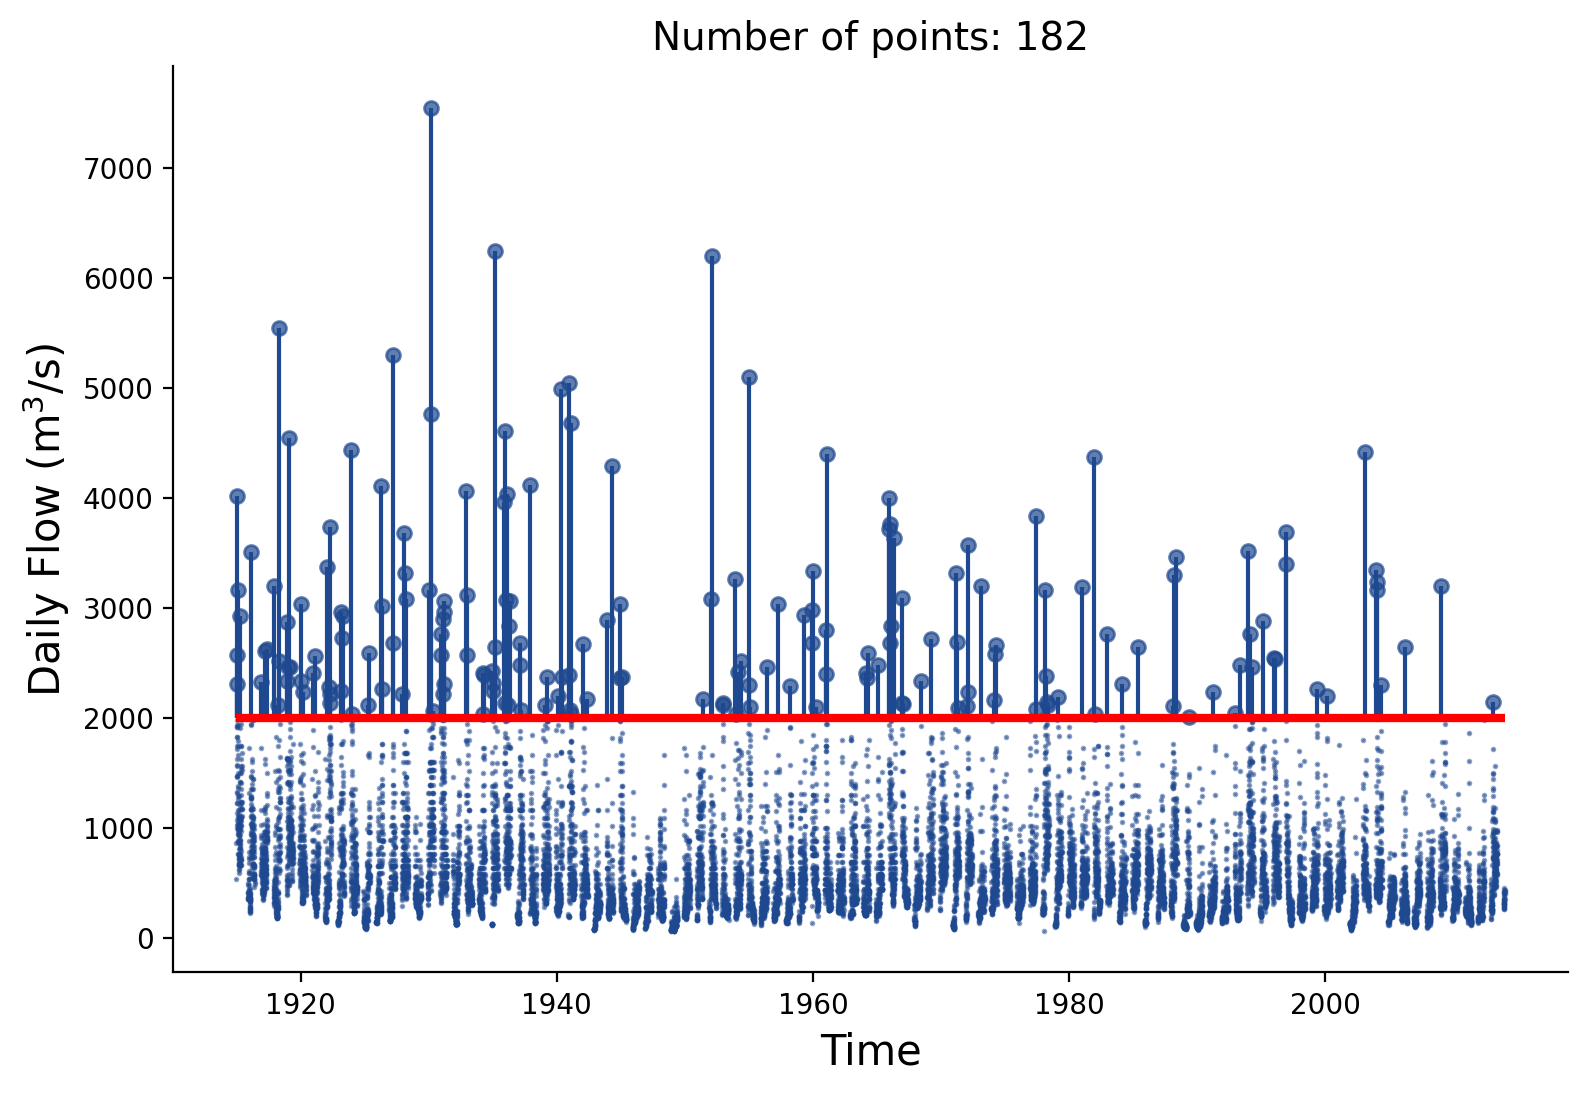

In [4]:
time_scale = range(len(observations_under_u)+n_obs)

fig = plt.figure(figsize=(9, 6), dpi=200)
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(time_under_u, observations_under_u, '.', color=COLOR_LIST[0], alpha=0.5, ms=2)
ax.vlines(time, [threshold], obs, colors=COLOR_LIST[0])

ax.plot(time, obs, ".", alpha = 0.7, linewidth=1.5, ms = 10, color=COLOR_LIST[0])

ax.hlines(threshold, min(time + time_under_u), max(time + time_under_u), colors="r", linewidths=3)

ax.set_ylabel("Daily Flow (m$^3$/s)", fontsize = 15)
ax.set_xlabel("Time", fontsize = 15)

ax.set_title("Number of points: " + str(n_obs), fontsize=14)
plt.show()

# 2. MCMC

5000 draws of Metropolis-Hastings algorithm on the orthogonal parameterization, with different priors: 

- Config7: $p(r, \nu, \xi) \propto \displaystyle\frac{p_\mathrm{PC}(\xi \mid \lambda = 1)}{\nu}$

- Config8: $p(r, \nu, \xi) \propto \displaystyle\frac{p_\mathrm{PC}(\xi \mid \lambda = 10)}{\nu}$

- Config9: $p(r, \nu, \xi) \propto \displaystyle\frac{p_\mathrm{PC}(\xi \mid \lambda = 20)}{\nu}$

- Config10: $p(r, \nu, \xi) \propto \displaystyle\frac{p_\mathrm{PC}(\xi \mid \lambda = 10^3)}{\nu} \quad\quad$ ($\xi \approx 0$)

- Config11: $p(r, \nu, \xi) \propto p_\mathrm{J}(r, \nu, \xi) \propto \displaystyle\frac{r^{1/2}}{\nu (1+\xi) (1 + 2 \xi)^{1/2}}$
     

In [5]:
r_list = np.logspace(0.1, 4, 200)


mcmc_params_directory = "parameters/mcmc/"
poisson_params_directory = "parameters/poisson_simu/"

mcmc_configs = ["Config7", "Config8", "Config9", "Config10", "Config11"]

traces = []
names = []

for filename in mcmc_configs:
    print("\nConfig file: ", filename)
    mcmc_params = Params(mcmc_params_directory + filename + ".json")
    print(mcmc_params.name)

    nb_dim = len(mcmc_params.priors)
    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"]]

    if nb_dim == 3:
        priors.append(mcmc_params.priors["p3"])

        if mcmc_params.init_p1_by_u:
            init_val = n_obs if mcmc_params.orthogonal_param else threshold
            priors[2] = priors[2].replace("u", str(init_val))

    MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                       obs=obs, u=threshold, m=n_years, period_range=r_list,
                       orthogonal_param=mcmc_params.orthogonal_param)
    if mcmc_params.update_m != "":
        MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)

    trace = MCMC.run(verbose=False)

    names.append(mcmc_params.name)
    traces.append(trace)


Config file:  Config7
$\lambda = 1$

Config file:  Config8
$\lambda = 10$

Config file:  Config9
$\lambda = 20$

Config file:  Config10
$\lambda = 1000$

Config file:  Config11
Jeffreys


### Convergence diagnostic

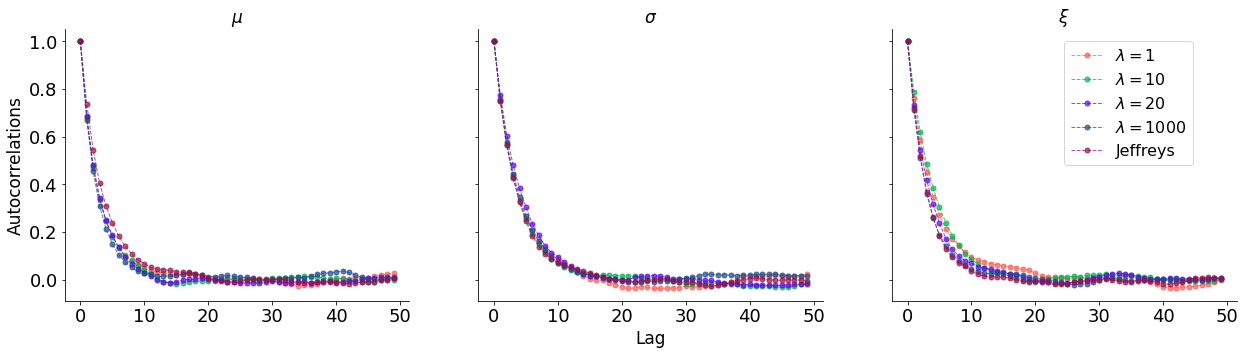

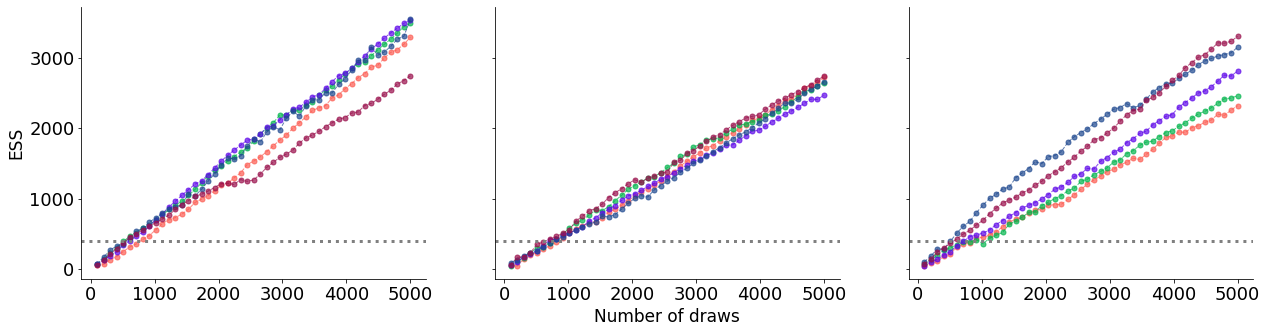

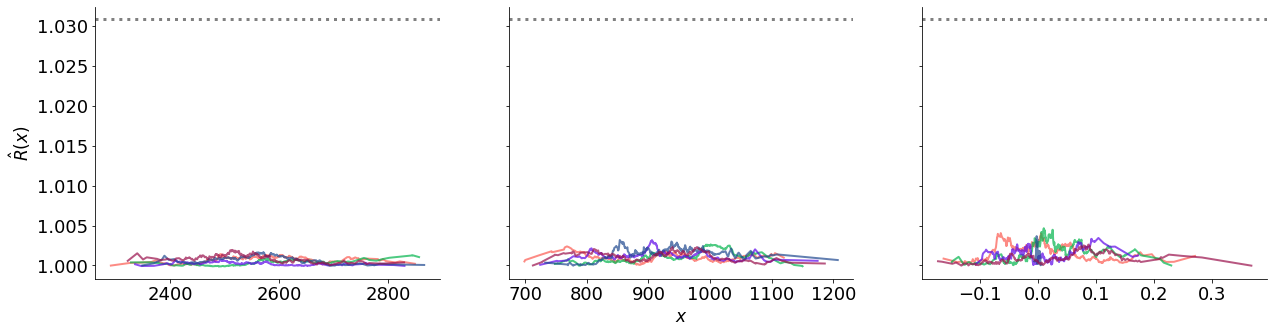

In [6]:
var_names = ["mu_m", "sig_m", "xi"]            
plot_autocorr(traces = traces, labels = names, var_names = var_names)
plot_ess(traces = traces, labels = names, var_names = var_names)
plot_r_hat_x(traces = traces, labels = names, var_names = var_names)

# 3. Return level estimation

In [7]:
def extract_annual_maxima():
    _, obs, _, time = extract_data(threshold = 1)
        
    res = []
    idx = 0
    
    while idx < len(obs)-1:
        current_max = obs[idx]
        idx += 1
        while idx < len(obs) and time[idx].year == time[idx-1].year:
            current_max = max(current_max, obs[idx])
            idx += 1
        res.append(current_max)
    
    if idx < len(obs) and time[idx].year != time[idx-1].year:
        res.append(obs[idx])
    
    return res


In [8]:
from matplotlib.ticker import NullFormatter


def return_level(mu,sig,xi,yp):
    # yp = -np.log(1-1/r)
    return mu - sig/xi * (1 - yp**(-xi))

def return_level_0(mu,sig,xi,yp):
    # yp = -np.log(1-1/r)
    return mu - sig * np.log(yp)


def get_return_level(r, trace, param, light_tail=False):
    y = -np.log(1-1/r)
    
    level_function = return_level_0 if light_tail else return_level
    
    return level_function(param["mu_m"], param["sig_m"], param["xi"], y) 



def plot_return_level(trace, r_list, method = "l2", n_data_plotted = 60, light_tail=False, ylabel=True):
        
    if method == "l1":
        param = az.summary(data=trace, hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["mean"]
        levels_mean = [get_return_level(r, trace, param, light_tail) for r in r_list]
        param = az.summary(data=trace, hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
        levels_hdi1 = [get_return_level(r, trace, param, light_tail) for r in r_list]
        param = az.summary(data=trace, hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]
        levels_hdi2 = [get_return_level(r, trace, param, light_tail) for r in r_list]

    elif method == "l2":
        levels_mean = np.asarray(az.summary(data=trace, hdi_prob = 0.95, var_names=["q"])["mean"])
        levels_hdi1 = np.asarray(az.summary(data=trace, hdi_prob = 0.95, var_names=["q"])["hdi_2.5%"])
        levels_hdi2 = np.asarray(az.summary(data=trace, hdi_prob = 0.95, var_names=["q"])["hdi_97.5%"])

    fig = plt.figure(figsize=(15,12), dpi = 300)
    ax = fig.add_subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(2e3, 2e4)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

    
    plt.plot(r_list, levels_mean, "-", color=COLOR_LIST[1], linewidth = 2)
    plt.plot(r_list, levels_hdi1, "--", color=COLOR_LIST[0], linewidth = 3)
    plt.plot(r_list, levels_hdi2, "--", color=COLOR_LIST[0], linewidth = 3)

    annual_max = np.sort(extract_annual_maxima())[::-1]

    empirical_r = [(n_years)/(i+1) for i in range(n_data_plotted)]
    
    plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)
    plt.plot(empirical_r, annual_max[:n_data_plotted], ".", color="black", ms=15)
    plt.xlabel("Return Period (years)",  fontsize = 17)
    plt.ylabel("Return Level (m$^3$/s)",  fontsize = 17)

    if ylabel:
        plt.legend(["Post. mean", "95%-CI"], fontsize = 17)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())

    

### $\lambda$ = 10:

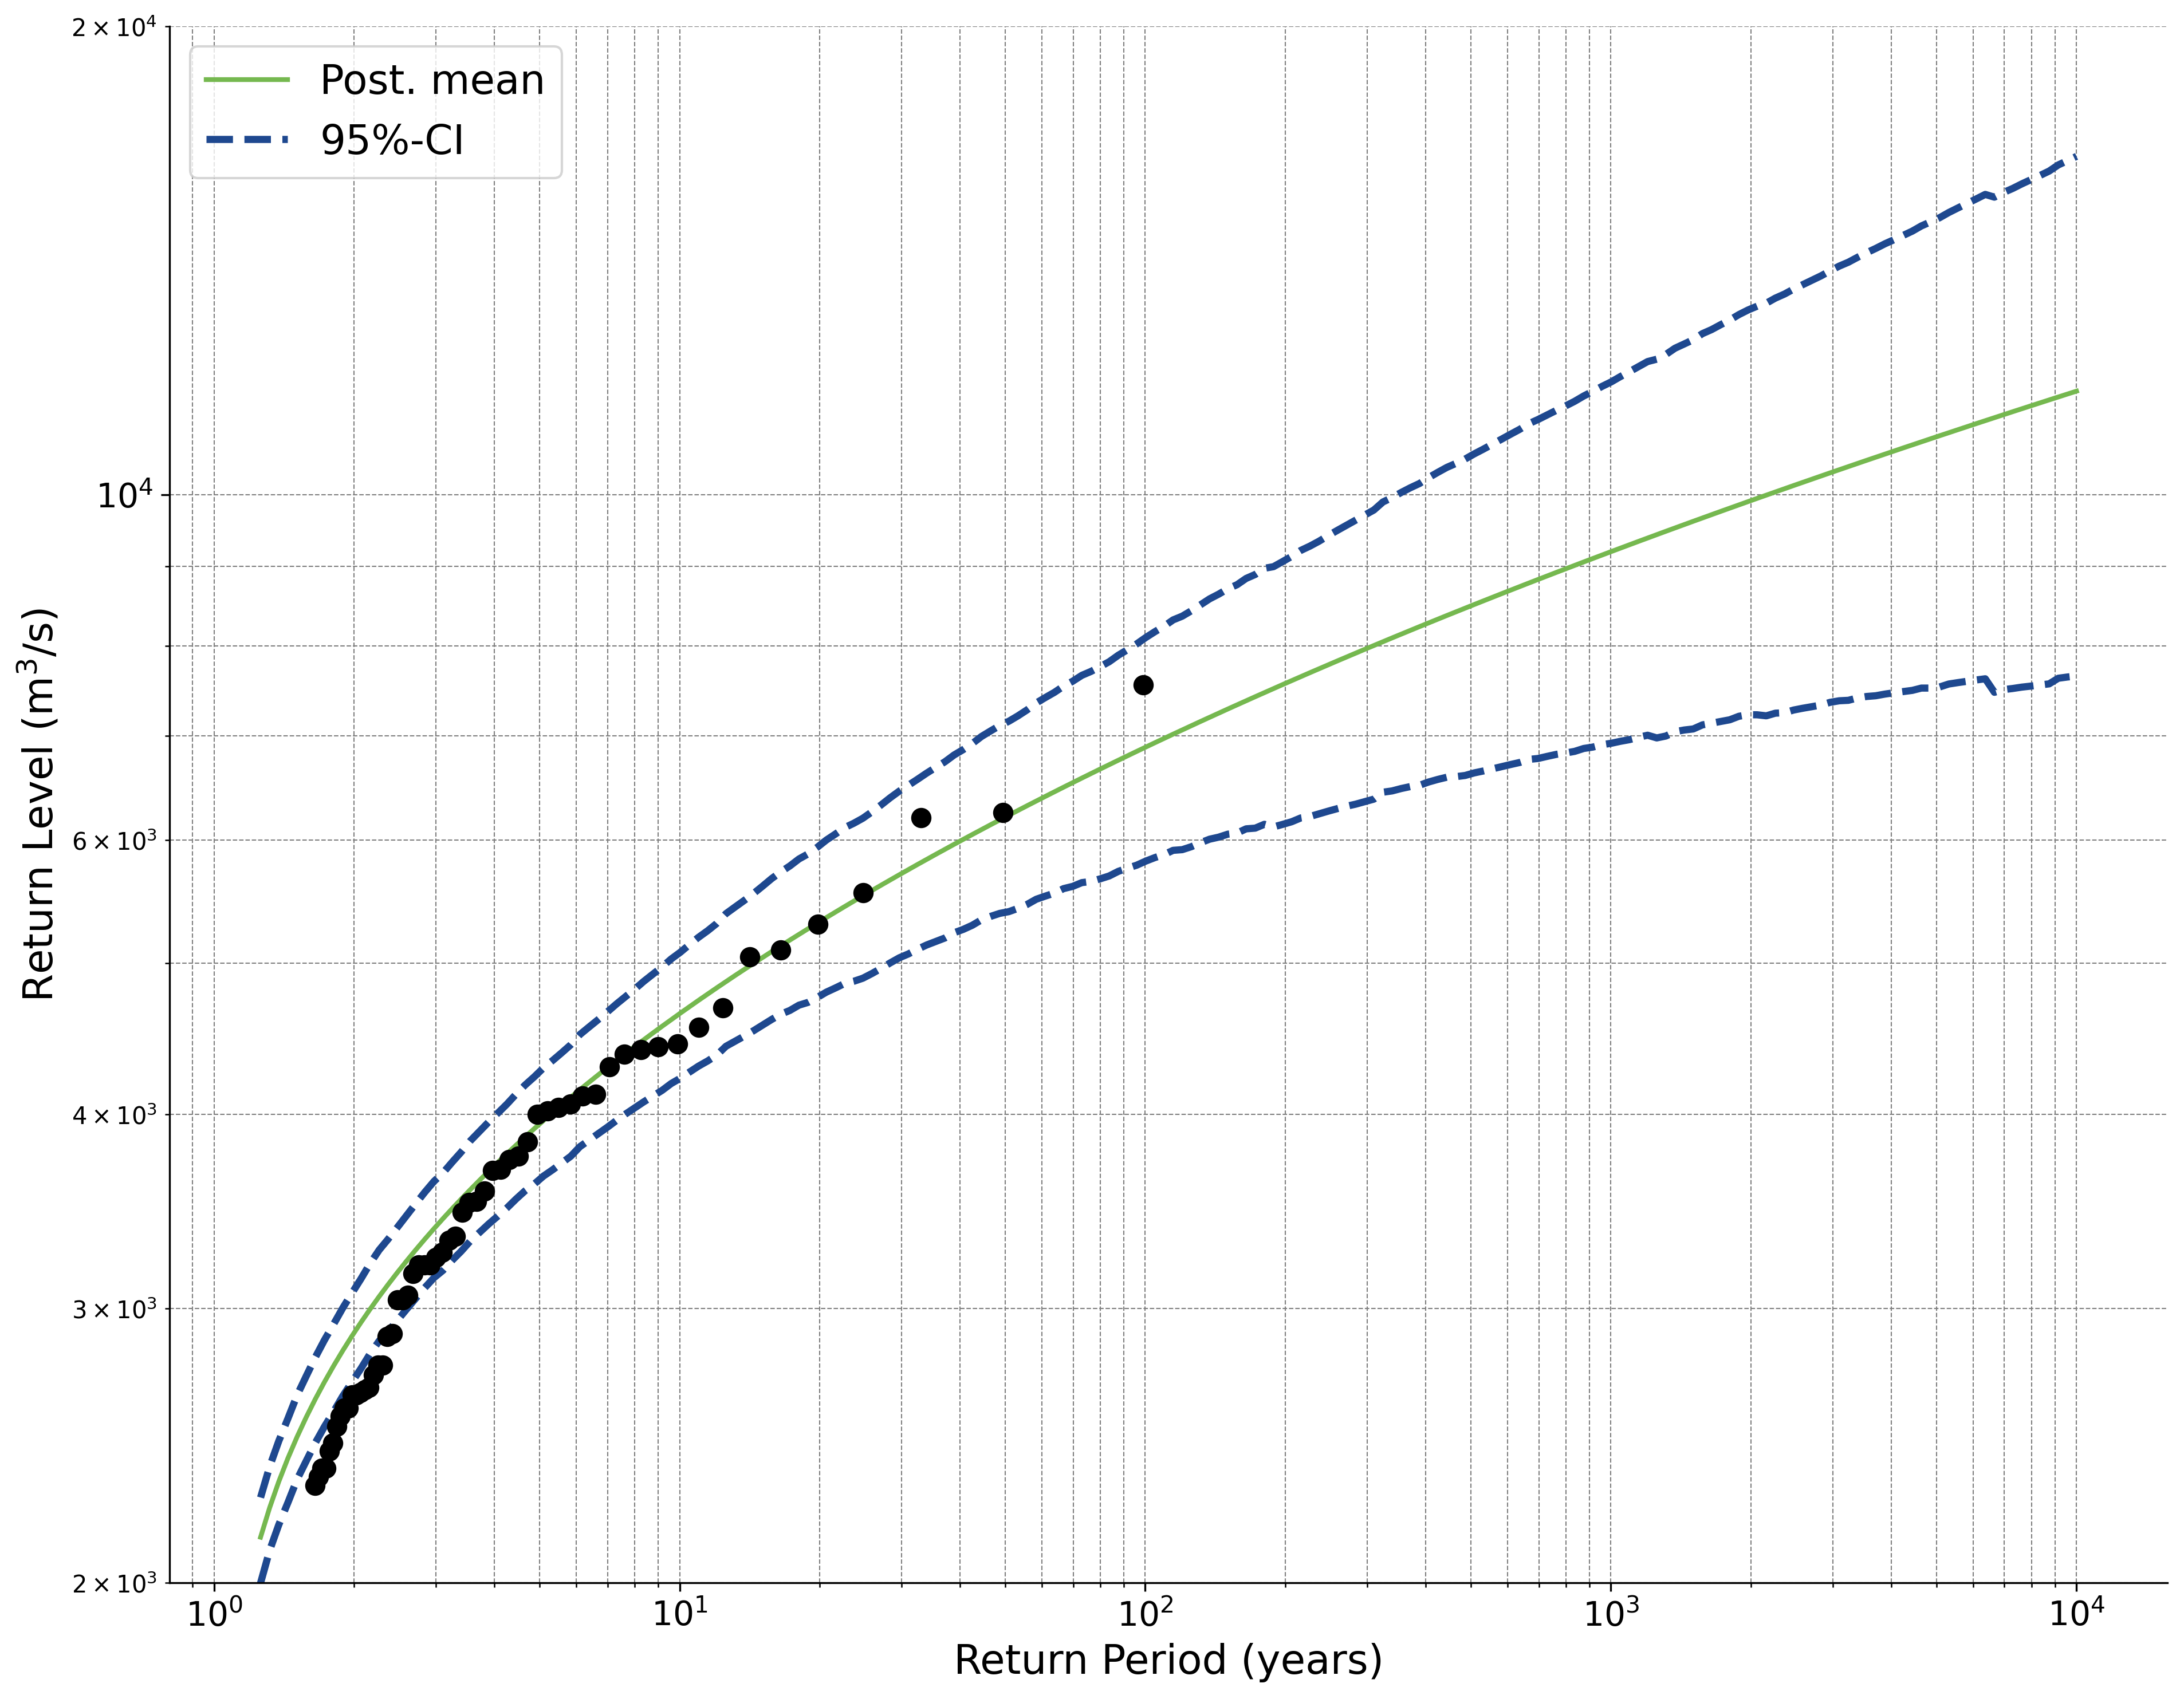

In [9]:
plot_return_level(traces[1], r_list)
plt.show()

In [10]:
param_mean = az.summary(data=traces[1], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["mean"]
param_hdi1 = az.summary(data=traces[1], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
param_hdi2 = az.summary(data=traces[1], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]

print("Method 1:")
print(get_return_level(r = 1000, trace = traces[1], param = param_hdi1))
print(get_return_level(r = 1000, trace = traces[1], param = param_mean))
print(get_return_level(r = 1000, trace = traces[1], param = param_hdi2))
print("")

print("Method 2:")
print(az.summary(data=traces[1], hdi_prob = 0.95, var_names=["q"])["hdi_2.5%"][148])
print(az.summary(data=traces[1], hdi_prob = 0.95, var_names=["q"])["mean"][148])
print(az.summary(data=traces[1], hdi_prob = 0.95, var_names=["q"])["hdi_97.5%"][148])

Method 1:
6282.9504213133405
9046.988651734471
14190.870316938233

Method 2:
6924.152
9194.648
11818.042


### $\lambda$ = 1:

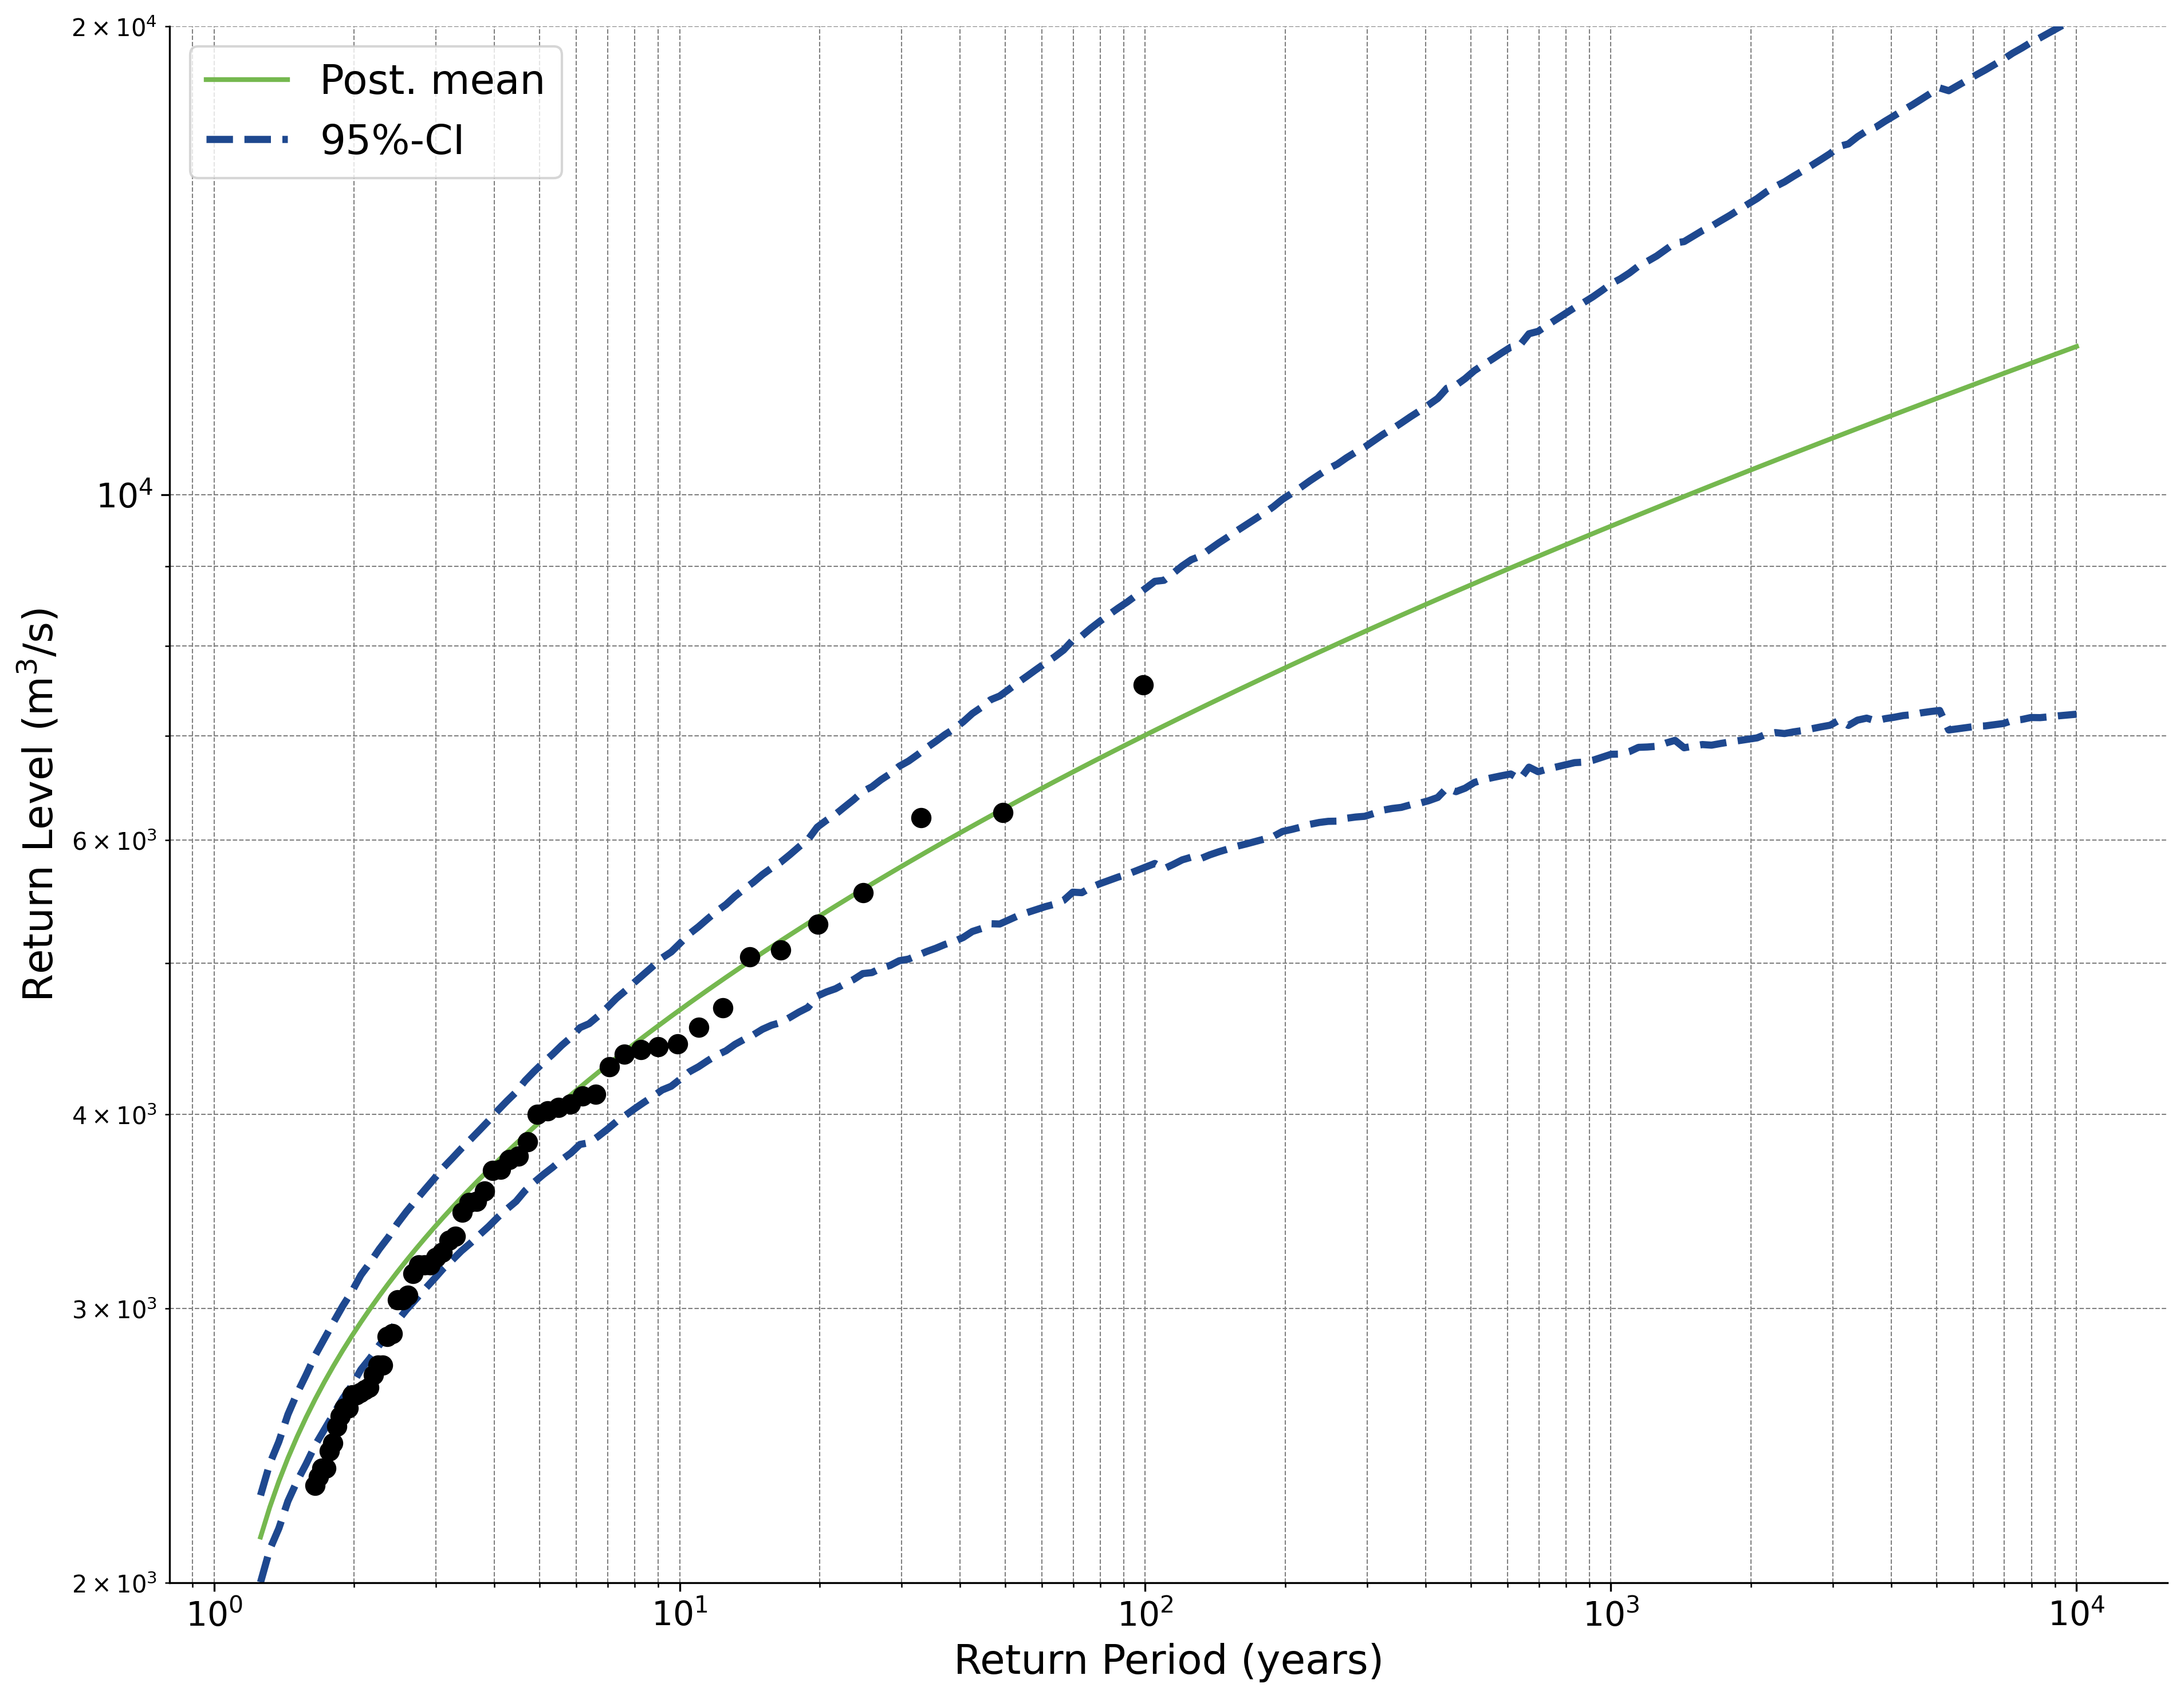

In [11]:
plot_return_level(traces[0], r_list)
plt.show()

In [12]:
param_mean = az.summary(data=traces[0], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["mean"]
param_hdi1 = az.summary(data=traces[0], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
param_hdi2 = az.summary(data=traces[0], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]

print("Method 1:")
print(get_return_level(r = 1000, trace = traces[0], param = param_hdi1))
print(get_return_level(r = 1000, trace = traces[0], param = param_mean))
print(get_return_level(r = 1000, trace = traces[0], param = param_hdi2))
print("")

print("Method 2:")
print(az.summary(data=traces[0], hdi_prob = 0.95, var_names=["q"])["hdi_2.5%"][148])
print(az.summary(data=traces[0], hdi_prob = 0.95, var_names=["q"])["mean"][148])
print(az.summary(data=traces[0], hdi_prob = 0.95, var_names=["q"])["hdi_97.5%"][148])

Method 1:
5947.201769416988
9238.723541882813
16371.946525977699

Method 2:
6812.775
9549.065
13666.445


### Case $\xi = 0$:

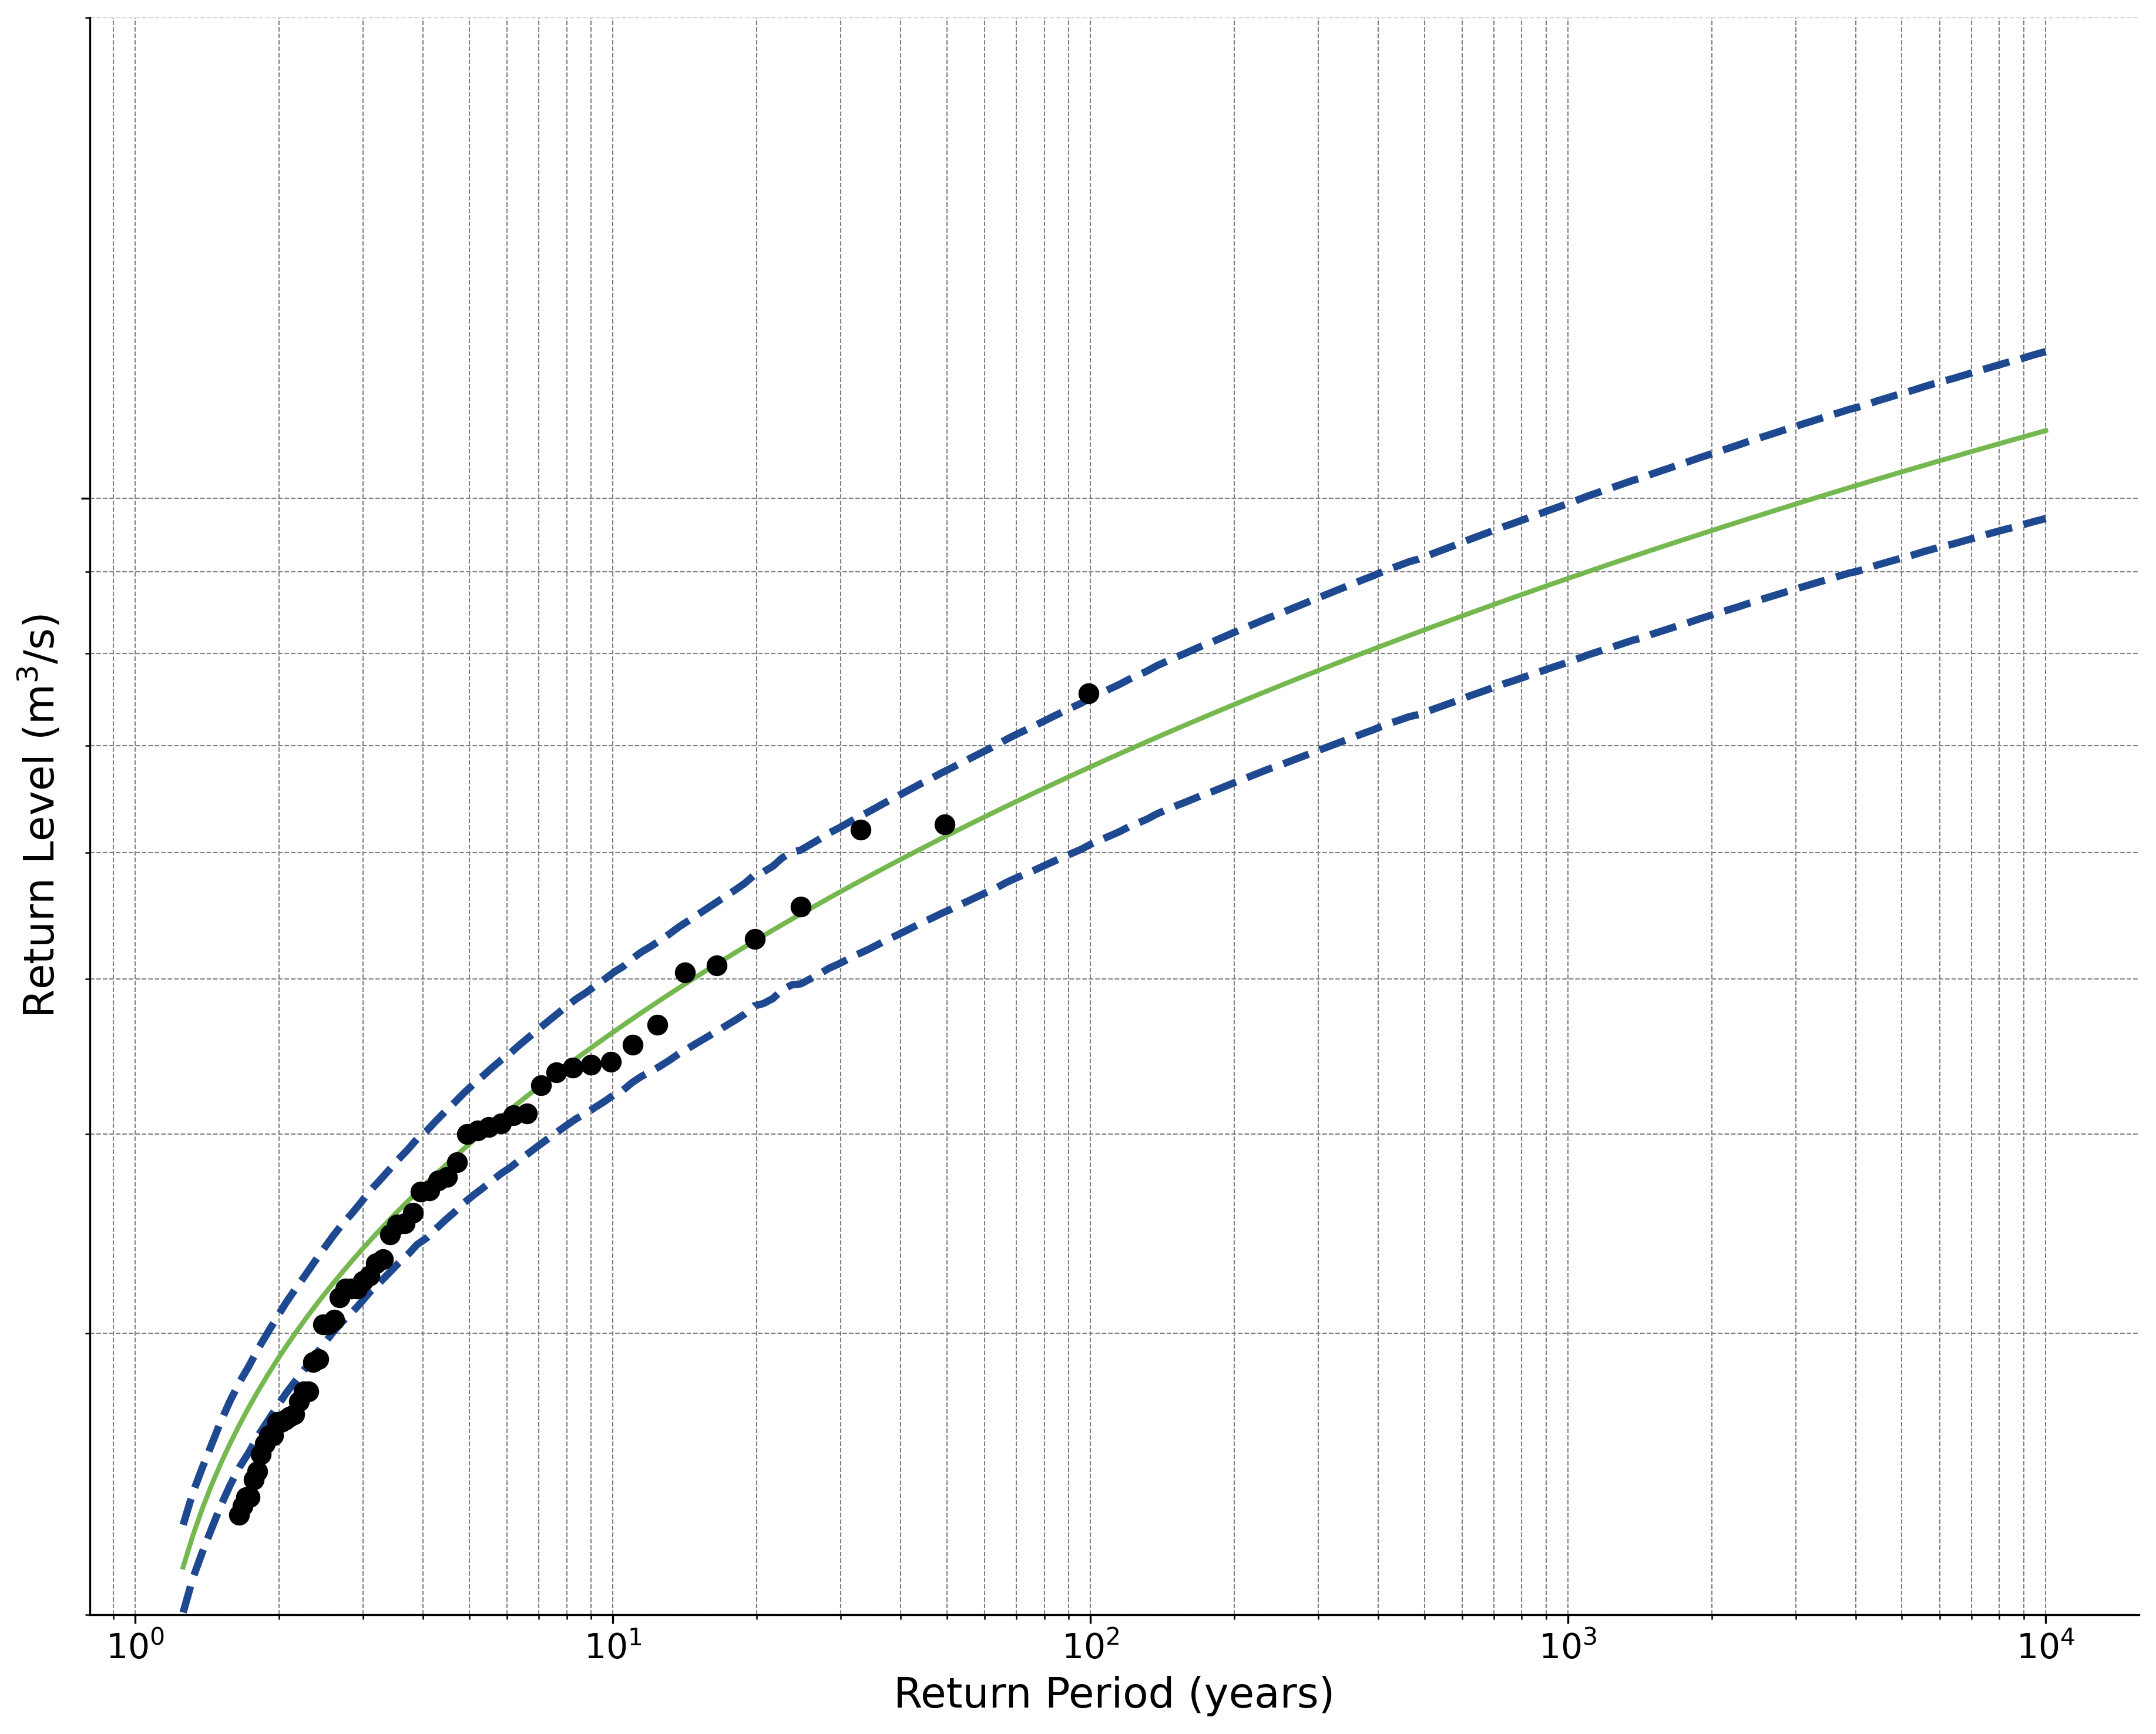

In [13]:
plot_return_level(traces[3], r_list, light_tail=True, ylabel = False)
plt.show()

In [14]:
param_mean = az.summary(data=traces[3], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["mean"]
param_hdi1 = az.summary(data=traces[3], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
param_hdi2 = az.summary(data=traces[3], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]

print("Method 1:")
print(get_return_level(r = 1000, trace = traces[3], param = param_hdi1))
print(get_return_level(r = 1000, trace = traces[3], param = param_mean))
print(get_return_level(r = 1000, trace = traces[3], param = param_hdi2))
print("")

print("Method 2:")
print(az.summary(data=traces[3], hdi_prob = 0.95, var_names=["q"])["hdi_2.5%"][148])
print(az.summary(data=traces[3], hdi_prob = 0.95, var_names=["q"])["mean"][148])
print(az.summary(data=traces[3], hdi_prob = 0.95, var_names=["q"])["hdi_97.5%"][148])

Method 1:
7809.580633278201
nan
10093.575457432114

Method 2:
7897.783
8911.617
9927.203


### Comparison of CI length

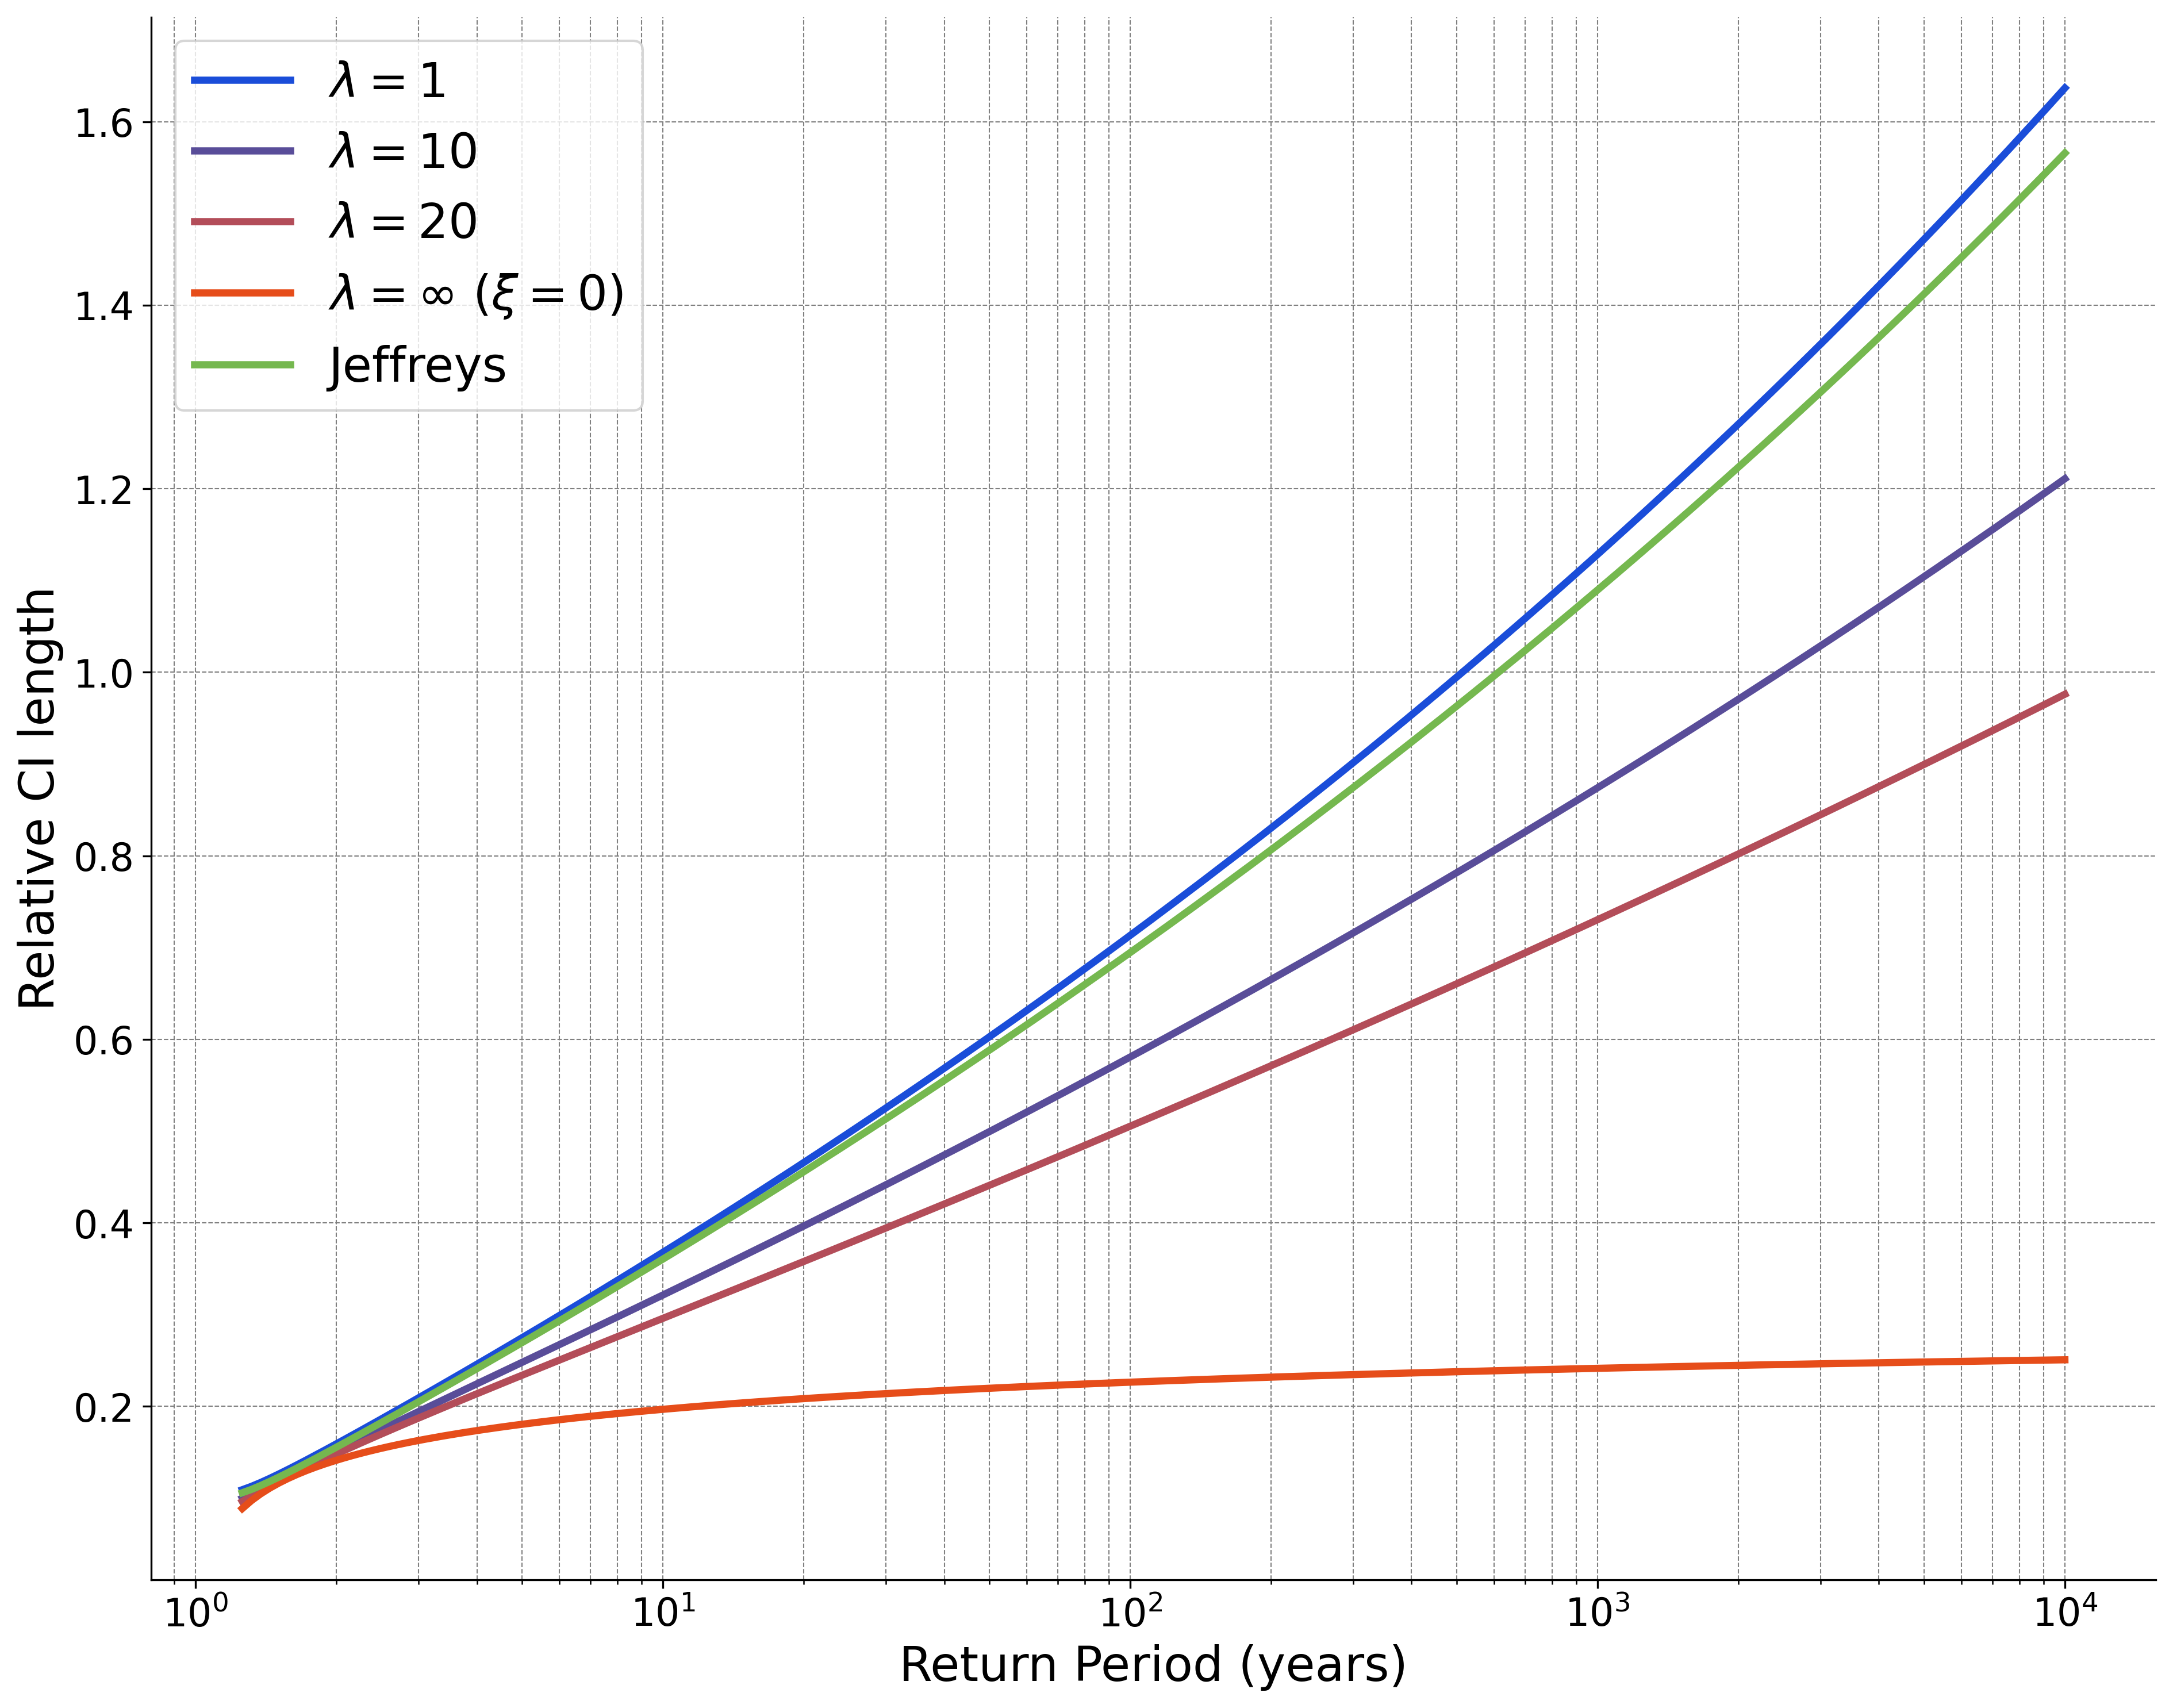

In [15]:

light_tail_list = [False, False, False, True, False]

r_list = np.logspace(0.1, 4, 200)

fig = plt.figure(figsize=(15,12), dpi=300)
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

col_list = [(0.1, 0.3, 0.85), (0.35, 0.3, 0.6), (0.7, 0.3, 0.35), 
            (0.9, 0.3, 0.1), COLOR_LIST[1]]

for i, trace in enumerate(traces):
    
    param_mean = az.summary(data=trace, hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["mean"]
    param_hdi1 = az.summary(data=trace, hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
    param_hdi2 = az.summary(data=trace, hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]
    
    levels_mean = [get_return_level(r, trace, param_mean, light_tail=light_tail_list[i]) for r in r_list]
    levels_hdi1 = [get_return_level(r, trace, param_hdi1, light_tail=light_tail_list[i]) for r in r_list]
    levels_hdi2 = [get_return_level(r, trace, param_hdi2, light_tail=light_tail_list[i]) for r in r_list]

    relative_length = [(i2-i1)/m for (m, i1, i2) in zip(levels_mean, levels_hdi1, levels_hdi2)]
    

    plt.plot(r_list, relative_length, "-", color=col_list[i], 
             linewidth = 3)
    plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)

    plt.xlabel("Return Period (years)",  fontsize = 20)
    plt.ylabel("Relative CI length",  fontsize = 20)
    plt.legend(["$\lambda = 1$", 
                "$\lambda = 10$", 
                "$\lambda = 20$", 
                "$\lambda = \infty$ ($\\xi = 0$)",
                "Jeffreys"], fontsize = 20)

plt.show()

### Comparison of posterior mean return level

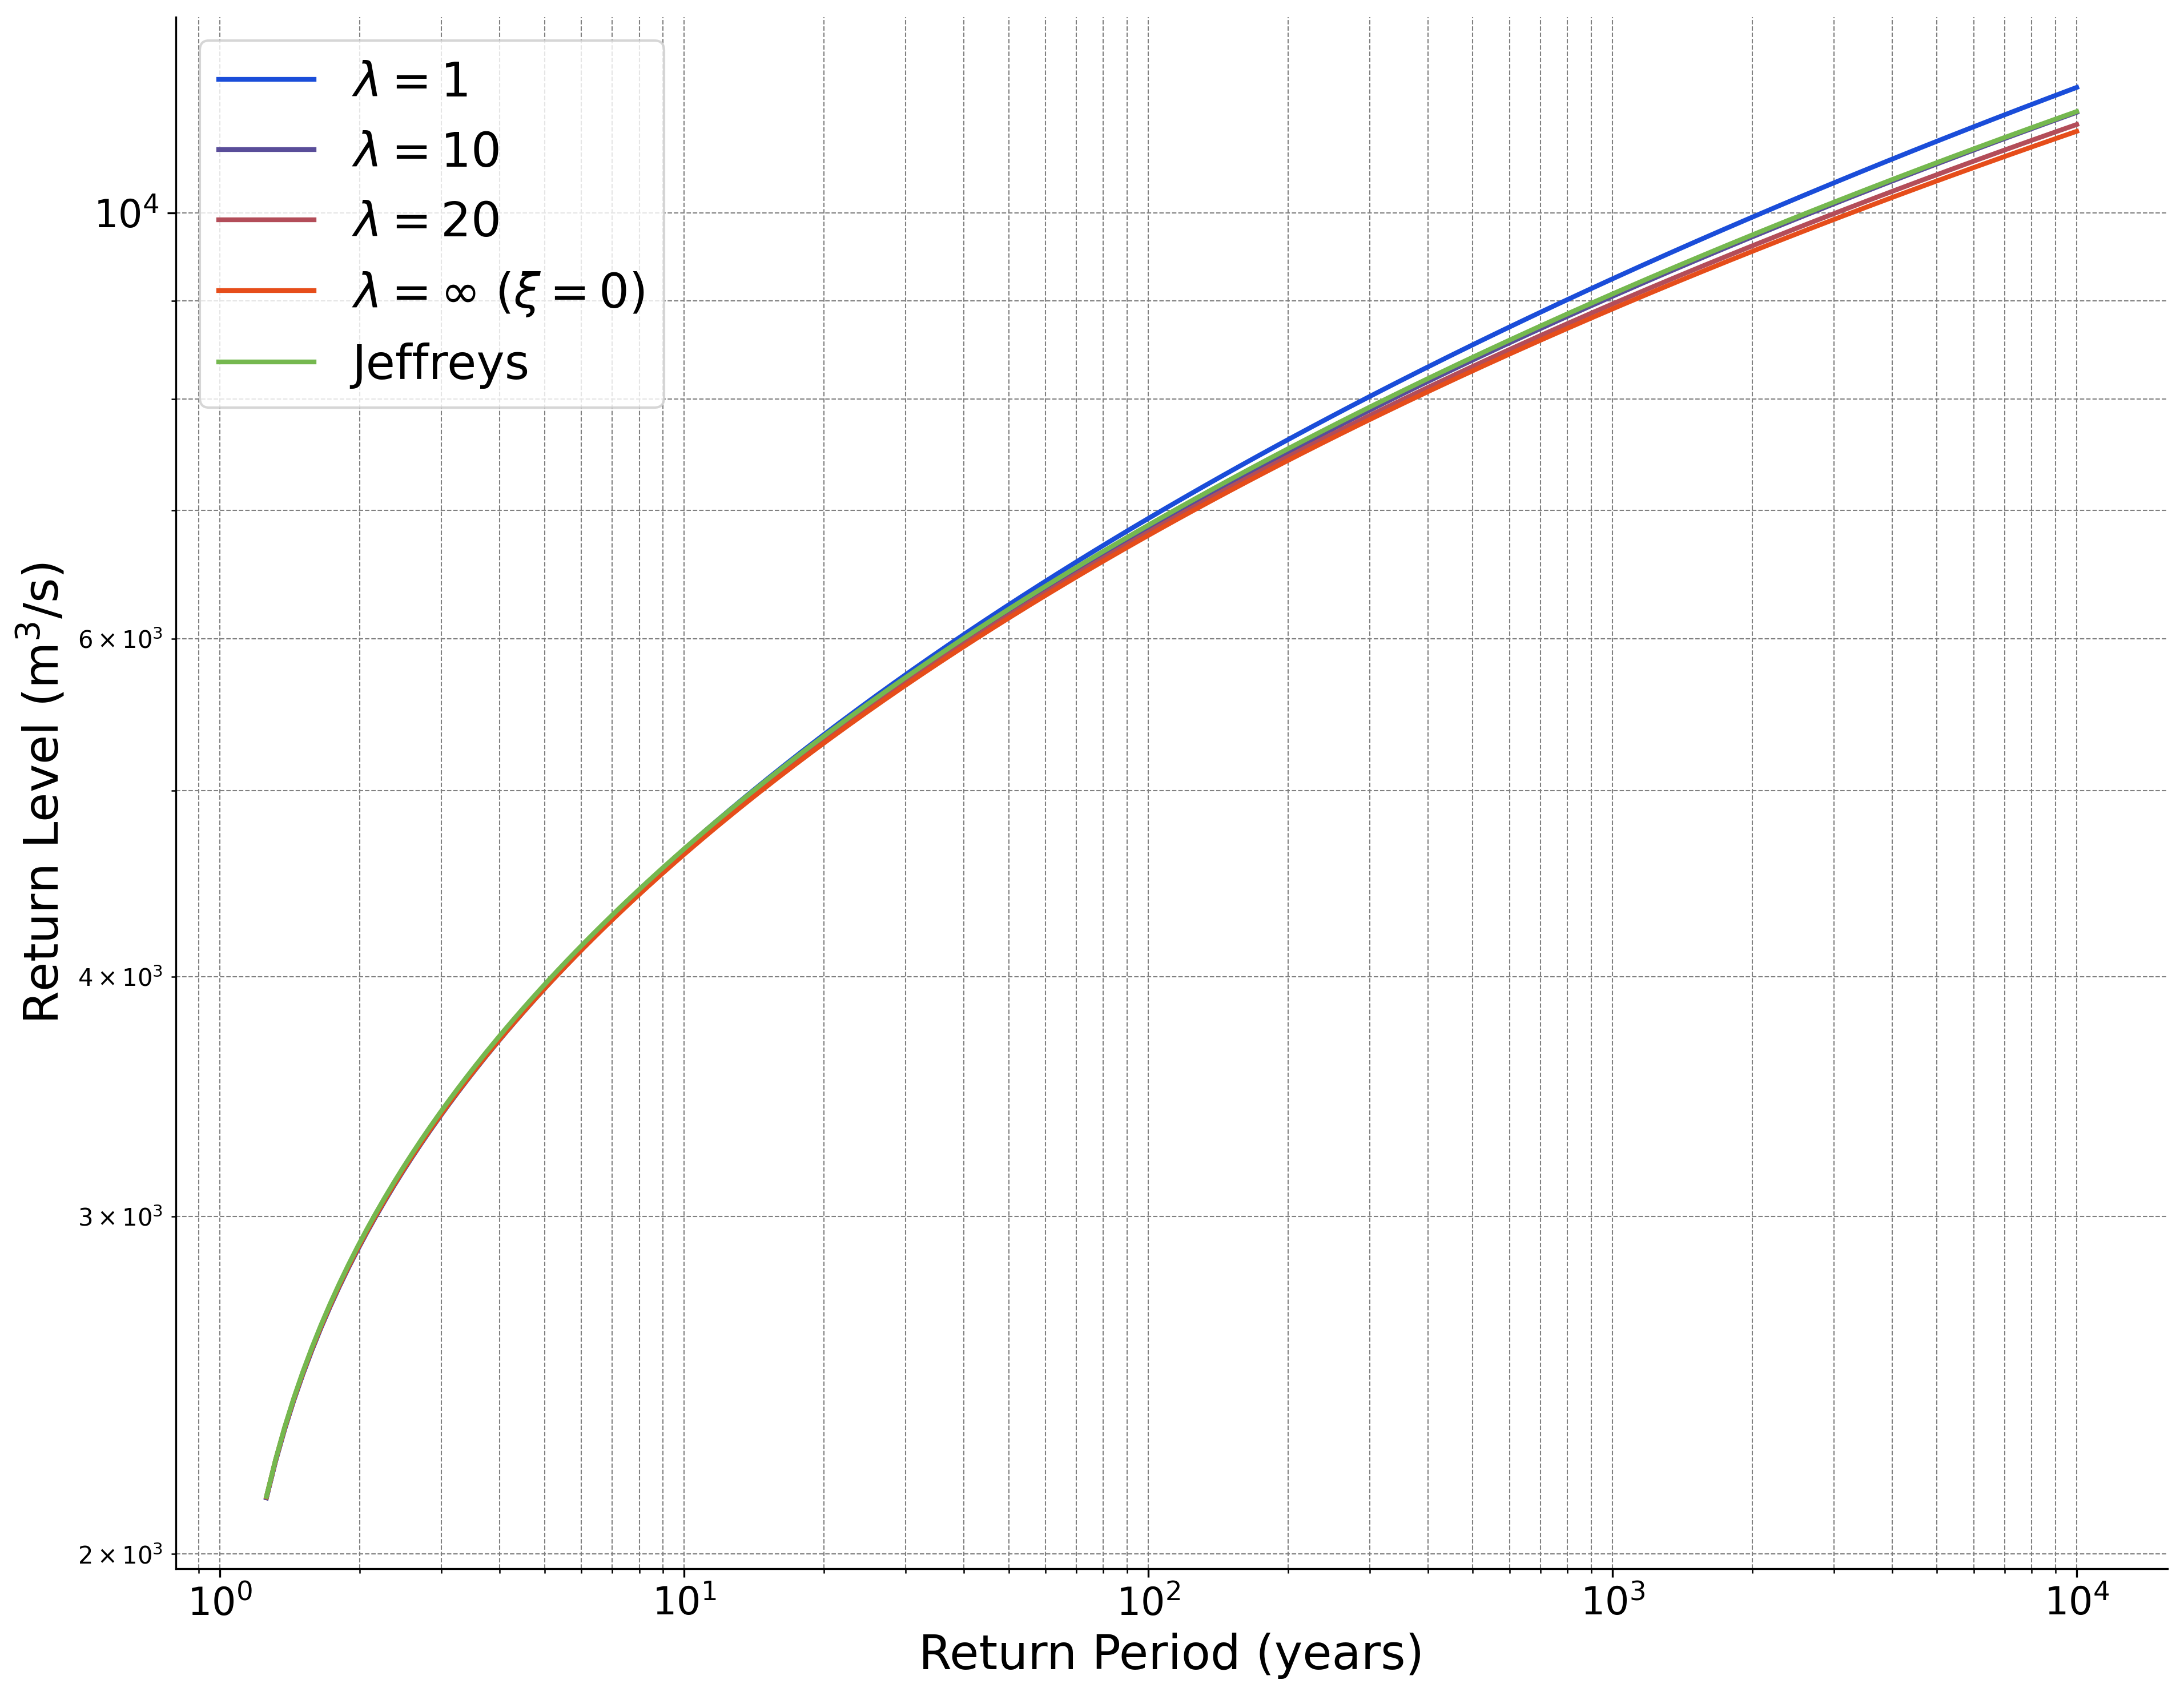

In [16]:

light_tail_list = [False, False, False, True]

r_list = np.logspace(0.1, 4, 200)

fig = plt.figure(figsize=(15,12), dpi=300)
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


col_list = [(0.1, 0.3, 0.85), (0.35, 0.3, 0.6), (0.7, 0.3, 0.35), 
            (0.9, 0.3, 0.1), COLOR_LIST[1]]

param_mean_jeffreys = az.summary(data=traces[-1], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["mean"]
levels_mean_jeffreys = [get_return_level(r, traces[-1], param_mean_jeffreys, light_tail=False) for r in r_list]

for i, tail_bool in enumerate(light_tail_list):
    
    param_mean = az.summary(data=traces[i], hdi_prob = 0.95, var_names=["mu_m", "sig_m", "xi"])["mean"]
    levels_mean = [get_return_level(r, traces[i], param_mean, light_tail=tail_bool) for r in r_list]

    plt.plot(r_list, levels_mean, "-", color=col_list[i], linewidth = 2)

plt.plot(r_list, levels_mean_jeffreys, "-", color=col_list[-1], linewidth = 2)
plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)

plt.xlabel("Return Period (years)",  fontsize = 20)
plt.ylabel("Return Level (m$^3$/s)",  fontsize = 20)
plt.legend(["$\lambda = 1$", 
            "$\lambda = 10$", 
            "$\lambda = 20$", 
            "$\lambda = \infty$ ($\\xi = 0$)",
            "Jeffreys"], fontsize = 20)

plt.show()